## Manual Creation of RNN

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
num_inputs = 2
num_neurons = 3

In [3]:
# PLACEHOLDERS
x0 = tf.placeholder(tf.float32,shape=[None,num_inputs])

In [4]:
x1 = tf.placeholder(tf.float32,shape=[None,num_inputs])

In [5]:
# Variables

In [6]:
Wx = tf.Variable(tf.random_normal(shape=[num_inputs,num_neurons]))

In [7]:
Wy = tf.Variable(tf.random_normal(shape=[num_neurons,num_neurons]))

In [8]:
b  = tf.Variable(tf.zeros([1,num_neurons]))

In [9]:
# Graphs

In [10]:
y0 = tf.tanh(tf.matmul(x0, Wx) + b)

In [11]:
y1 = tf.tanh(tf.matmul(y0,Wy) + tf.matmul(x1, Wx) + b)

In [12]:
init = tf.global_variables_initializer()

In [13]:
x0_batch  = np.array([[0,1],[2,3],[4,5]]) #TIMESTAMP 0
x1_batch  = np.array([[100,101],[102,103],[104,105]]) #TIMESTAMP 0

In [14]:
with tf.Session() as sess:
    sess.run(init)
    
    y0_output_vals, y1_output_vals = sess.run([y0,y1],feed_dict={x0:x0_batch,x1:x1_batch})

In [15]:
y1_output_vals

array([[ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.]], dtype=float32)

In [16]:
y0_output_vals

array([[-0.3588312 ,  0.14399953,  0.70334786],
       [ 0.9968297 , -0.491242  ,  0.01438852],
       [ 0.9999978 , -0.83977205, -0.68850946]], dtype=float32)

## Vanishing Gradients

## LSTM and GRU Theory

## RNN with TF P - I

In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax-self.xmin -(steps*self.resolution))
        
        # Create batch time series on the x axis
        batch_ts =ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        # FORMATTING for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

In [19]:
ts_data = TimeSeriesData(250,0,10)

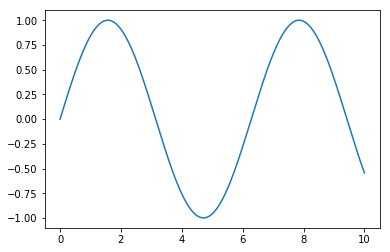

In [20]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [21]:
num_time_steps = 30

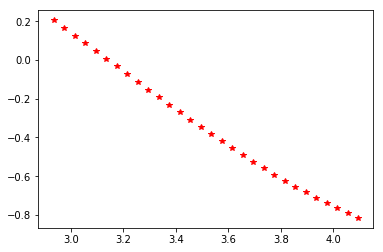

In [22]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

plt.plot(ts.flatten()[1:],y2.flatten(),'r*')

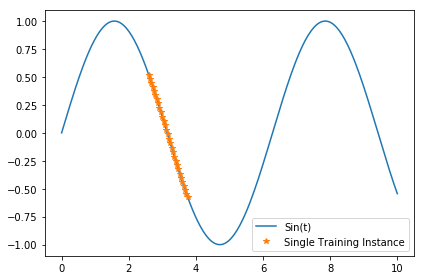

In [23]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

In [24]:
# Training Data

In [25]:
train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps+1),num_time_steps+1)

In [26]:
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

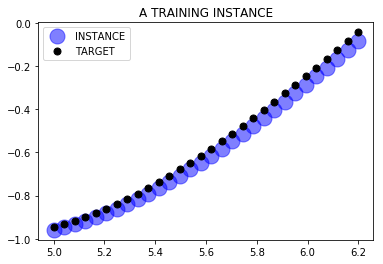

In [27]:
plt.title('A TRAINING INSTANCE')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize = 15,alpha=0.5,label="INSTANCE")
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[1:]),'ko',markersize=7,label='TARGET')
plt.legend()

## Creating the model

In [28]:
tf.reset_default_graph()

In [29]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.001
num_train_iterations = 2000
bacth_size = 1

In [30]:
# PALCEHOLDERS
X = tf.placeholder(tf.float32,shape=[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,shape=[None,num_time_steps,num_outputs])

In [31]:
# RNN CELL LAYER
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(
        num_units=num_neurons,
        activation=tf.nn.relu),
    output_size=num_outputs)

In [32]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)

In [33]:
# Calculate MSE
loss = tf.reduce_mean(tf.square(outputs-y))

In [34]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [35]:
# saver function
saver = tf.train.Saver()

In [36]:
# Run Session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for iteration in range(num_train_iterations):
        X_batch, y_batch = ts_data.next_batch(bacth_size,num_time_steps)
        sess.run(train,feed_dict = {X:X_batch,y:y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict = {X:X_batch,y:y_batch})
            print(iteration,"\tMSE",mse)
        
    saver.save(sess,
               "C:\\Users\\manish.singh04\\Videos\\Tensorflow-Bootcamp-master\\04-Recurrent-Neural-Networks/Output_Results/rnn_time_series_model_codeaong")

0 	MSE 0.37991565
100 	MSE 0.018580122
200 	MSE 0.0014657661
300 	MSE 0.0032359706
400 	MSE 0.012224606
500 	MSE 0.002356415
600 	MSE 0.010443468
700 	MSE 0.0010191707
800 	MSE 0.002947009
900 	MSE 0.0030597583
1000 	MSE 0.0025770427
1100 	MSE 0.00044960124
1200 	MSE 0.0001961782
1300 	MSE 0.00019252859
1400 	MSE 0.00013449967
1500 	MSE 0.00040061117
1600 	MSE 0.00010883808
1700 	MSE 0.00014954859
1800 	MSE 0.00011060746
1900 	MSE 0.00015350449


In [37]:
with tf.Session() as sess:
    saver.restore(sess,"C:\\Users\\manish.singh04\\Videos\\Tensorflow-Bootcamp-master\\04-Recurrent-Neural-Networks/Output_Results/rnn_time_series_model_codeaong")
    X_new =np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs,feed_dict = {X:X_new})

INFO:tensorflow:Restoring parameters from C:\Users\manish.singh04\Videos\Tensorflow-Bootcamp-master\04-Recurrent-Neural-Networks/Output_Results/rnn_time_series_model_codeaong


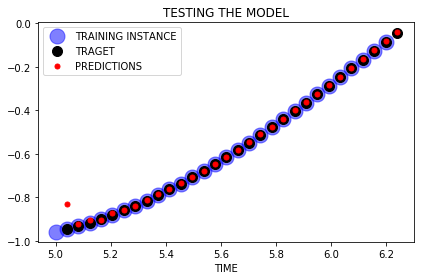

In [38]:
plt.title("TESTING THE MODEL")

# TRAINING INSTANCE
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha=0.5,label='TRAINING INSTANCE')

# TARGET TO PREDICT(CORRECT TEST VALUE NP.SIN(TRAIN))
plt.plot(train_inst[1:],np.sin(train_inst[1:]),"ko",markersize=10,label='TRAGET')

# MODEL PREDICTION
plt.plot(train_inst[1:],y_pred[0,:,0],"r.",markersize=10,label='PREDICTIONS')
plt.xlabel('TIME')
plt.legend()
plt.tight_layout()


# Generating New Sequence

In [39]:
range(num_time_steps)

range(0, 30)

In [40]:
with tf.Session() as sess:
    saver.restore(sess,
                  "C:\\Users\\manish.singh04\\Videos\\Tensorflow-Bootcamp-master\\04-Recurrent-Neural-Networks/Output_Results/rnn_time_series_model_codeaong")
    
    # SEED ZEROS
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for  iteration in range(len(ts_data.x_data) - num_time_steps):
        
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict = {X:X_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from C:\Users\manish.singh04\Videos\Tensorflow-Bootcamp-master\04-Recurrent-Neural-Networks/Output_Results/rnn_time_series_model_codeaong


In [41]:
len(zero_seq_seed)

250

Text(0,0.5,'Y')

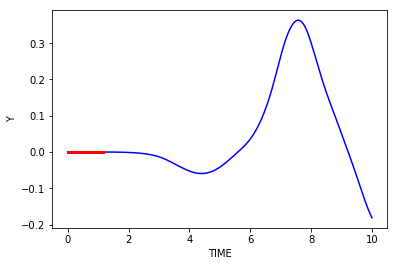

In [42]:
plt.plot(ts_data.x_data,zero_seq_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps],'r-',linewidth=3)
plt.xlabel('TIME')
plt.ylabel('Y')

In [43]:
with tf.Session() as sess:
    saver.restore(sess,
                  "C:\\Users\\manish.singh04\\Videos\\Tensorflow-Bootcamp-master\\04-Recurrent-Neural-Networks/Output_Results/rnn_time_series_model_codeaong")
    
    # SEED ZEROS
    training_instance = list(ts_data.y_true[:30])
    
    for  iteration in range(len(training_instance) - num_time_steps):
        
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict = {X:X_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from C:\Users\manish.singh04\Videos\Tensorflow-Bootcamp-master\04-Recurrent-Neural-Networks/Output_Results/rnn_time_series_model_codeaong


Text(0,0.5,'Y')

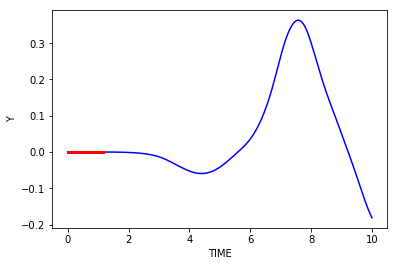

In [44]:
plt.plot(ts_data.x_data,zero_seq_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps],'r',linewidth=3)
plt.xlabel('TIME')
plt.ylabel('Y')